In [1]:
import numpy as np
import polars as pl
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
lf_1996 = pl.scan_csv("data/1996to2005.csv", ignore_errors=True).select("DATE", "DailyAverageDryBulbTemperature").drop_nulls()
lf_2015 = pl.scan_csv("data/2005to2015.csv", ignore_errors=True).select("DATE", "DailyAverageDryBulbTemperature").drop_nulls()
lf_2025 = pl.scan_csv("data/2015to2025.csv", ignore_errors=True).select("DATE", "DailyAverageDryBulbTemperature").drop_nulls()

In [3]:
lf_1996 = lf_1996.with_columns(
    pl.col("DailyAverageDryBulbTemperature").str.replace_all(r"[^0-9]", "").cast(pl.Int64).alias("TEMP")
)

lf_1996 = lf_1996.drop("DailyAverageDryBulbTemperature")

lf_2015 = lf_2015.rename({"DailyAverageDryBulbTemperature": "TEMP"})

lf_2025 = lf_2025.rename({"DailyAverageDryBulbTemperature": "TEMP"})

lf_full = pl.concat([lf_1996, lf_2015, lf_2025], how="vertical")

lf_full.collect()

DATE,TEMP
str,i64
"""1996-07-01T23:59:00""",83
"""1996-07-02T23:59:00""",83
"""1996-07-03T23:59:00""",82
"""1996-07-04T23:59:00""",79
"""1996-07-05T23:59:00""",80
…,…
"""2025-07-06T23:59:00""",81
"""2025-07-07T23:59:00""",80
"""2025-07-08T23:59:00""",80


In [4]:
intervals = lf_full.select("DATE").filter(pl.col("DATE").str.starts_with("1996-07-01") | pl.col("DATE").str.starts_with("2000-01-01") | pl.col("DATE").str.starts_with("2005-01-01") | pl.col("DATE").str.starts_with("2010-01-01") | pl.col("DATE").str.starts_with("2015-01-01") | pl.col("DATE").str.starts_with("2020-01-01") | pl.col("DATE").str.starts_with("2025-01-01")).collect().to_series()
intervals

DATE
str
"""1996-07-01T23:59:00"""
"""2000-01-01T23:59:00"""
"""2005-01-01T23:59:00"""
"""2010-01-01T23:59:00"""
"""2015-01-01T23:59:00"""
"""2020-01-01T23:59:00"""
"""2025-01-01T23:59:00"""


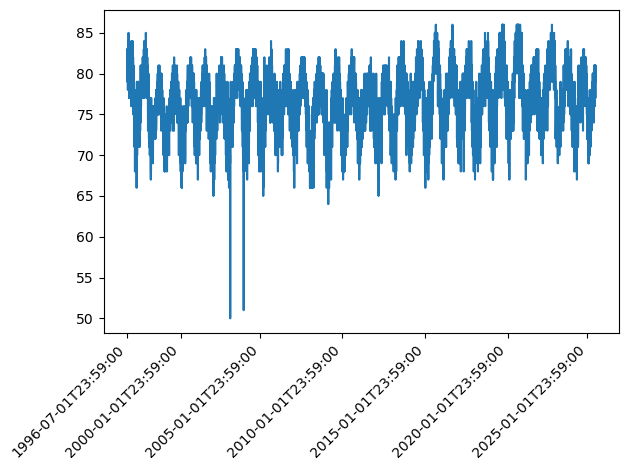

In [5]:
plt.plot(lf_full.select("DATE").collect().to_series(), lf_full.select("TEMP").collect().to_series())
plt.xticks(intervals, rotation=45, ha="right")
plt.tight_layout()

plt.show()

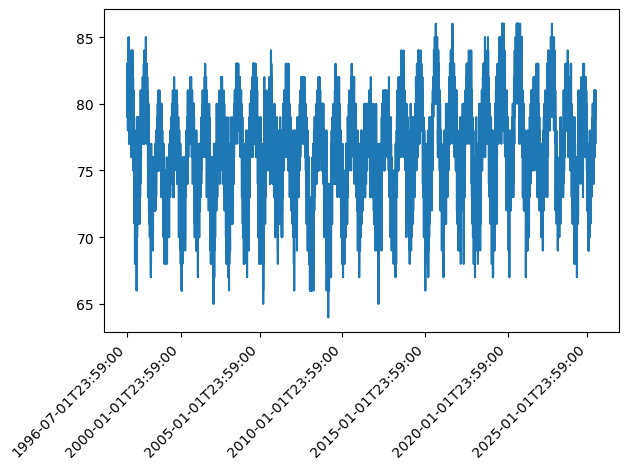

In [6]:
lf_full = lf_full.filter(pl.col("TEMP") > 55)
plt.plot(lf_full.select("DATE").collect().to_series(), lf_full.select("TEMP").collect().to_series())
plt.xticks(intervals, rotation=45, ha="right")
plt.tight_layout()

plt.show()

In [7]:
lf_full.describe()

statistic,DATE,TEMP
str,str,f64
"""count""","""10330""",10330.0
"""null_count""","""0""",0.0
"""mean""",null,76.638141
"""std""",null,3.677051
"""min""","""1996-07-01T23:59:00""",64.0
"""25%""",null,74.0
"""50%""",null,77.0
"""75%""",null,79.0
"""max""","""2025-07-10T23:59:00""",86.0


In [8]:
date_str = lf_full.select("DATE").collect().to_series().str.to_datetime("%Y-%m-%dT%H:%M:%S").dt

lf_full = lf_full.with_columns(
    date_str.year().alias("YEAR"),
    date_str.month().alias("MONTH"),
    date_str.day().alias("DAY"),
    date_str.hour().alias("HOUR"),
    date_str.minute().alias("MINUTE"),
    date_str.second().alias("SECOND")
    
)

lf_full.collect()

DATE,TEMP,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND
str,i64,i32,i8,i8,i8,i8,i8
"""1996-07-01T23:59:00""",83,1996,7,1,23,59,0
"""1996-07-02T23:59:00""",83,1996,7,2,23,59,0
"""1996-07-03T23:59:00""",82,1996,7,3,23,59,0
"""1996-07-04T23:59:00""",79,1996,7,4,23,59,0
"""1996-07-05T23:59:00""",80,1996,7,5,23,59,0
…,…,…,…,…,…,…,…
"""2025-07-06T23:59:00""",81,2025,7,6,23,59,0
"""2025-07-07T23:59:00""",80,2025,7,7,23,59,0
"""2025-07-08T23:59:00""",80,2025,7,8,23,59,0


In [9]:
lf_full = lf_full.select(["DATE", "YEAR", "MONTH", "DAY", "HOUR", "MINUTE", "SECOND", "TEMP"])
lf_full = lf_full.with_row_index()
lf_full.collect()

index,DATE,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,TEMP
u32,str,i32,i8,i8,i8,i8,i8,i64
0,"""1996-07-01T23:59:00""",1996,7,1,23,59,0,83
1,"""1996-07-02T23:59:00""",1996,7,2,23,59,0,83
2,"""1996-07-03T23:59:00""",1996,7,3,23,59,0,82
3,"""1996-07-04T23:59:00""",1996,7,4,23,59,0,79
4,"""1996-07-05T23:59:00""",1996,7,5,23,59,0,80
…,…,…,…,…,…,…,…,…
10325,"""2025-07-06T23:59:00""",2025,7,6,23,59,0,81
10326,"""2025-07-07T23:59:00""",2025,7,7,23,59,0,80
10327,"""2025-07-08T23:59:00""",2025,7,8,23,59,0,80


In [10]:
corr_schema = lf_full.drop("DATE").collect_schema()

for column in corr_schema.names():

    corr = lf_full.drop("DATE").select(pl.corr(column, "TEMP")).collect().item()
    print(f"{column}: {corr}") 

index: 0.14148376892383874
YEAR: 0.12538976446137035
MONTH: 0.42324397795515983
DAY: 0.015917693115134406
HOUR: nan
MINUTE: nan
SECOND: nan
TEMP: 1.0


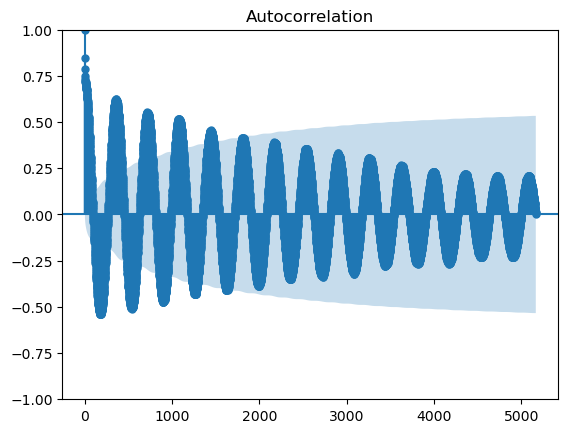

In [11]:
plot_acf(lf_full.select("TEMP").collect().to_series(), lags=len(lf_full.select("TEMP").collect().to_series()) // 2)
plt.show()

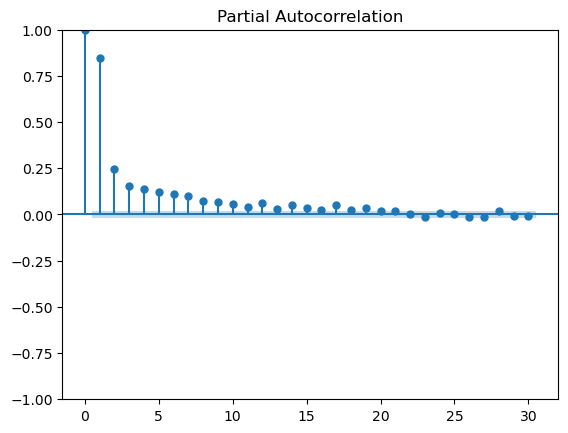

In [12]:
plot_pacf(lf_full.select("TEMP").collect().to_series(), lags=30)
plt.show()

In [13]:
lf_full = lf_full.with_columns(
    pl.when((pl.col("MONTH") >= 3) & (pl.col("MONTH") <= 5)).then(3)
    .when((pl.col("MONTH") >= 6) & (pl.col("MONTH") <= 8)).then(2)
    .when((pl.col("MONTH") >= 9) & (pl.col("MONTH") <= 11)).then(1)
    .otherwise(0).alias("SEASON")
)
lf_full = lf_full.select(["index", "DATE", "YEAR", "SEASON", "MONTH", "DAY", "HOUR", "MINUTE", "SECOND", "TEMP"])

In [14]:
corr_schema = lf_full.drop("DATE").collect_schema()

for column in corr_schema.names():

    corr = lf_full.drop("DATE").select(pl.corr(column, "TEMP")).collect().item()
    print(f"{column}: {corr}") 

index: 0.14148376892383874
YEAR: 0.12538976446137035
SEASON: 0.21422565514481115
MONTH: 0.42324397795515983
DAY: 0.015917693115134406
HOUR: nan
MINUTE: nan
SECOND: nan
TEMP: 1.0


In [15]:
soleq_lf = pl.scan_csv("data/solsticeequinox_hst.csv")
soleq_lf.collect()

YEAR,SPRING_DT,SUMMER_DT,AUTUMN_DT,WINTER_DT
i64,str,str,str,str
1996,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
1997,"""1997-03-20T03:54:00""","""1997-06-20T03:54:00""","""1997-09-22T13:55:00""","""1997-12-21T10:07:00"""
1998,"""1998-03-20T09:54:00""","""1998-06-21T04:02:00""","""1998-09-22T19:37:00""","""1998-12-21T15:56:00"""
1999,"""1999-03-20T15:46:00""","""1999-06-21T09:49:00""","""1999-09-23T01:31:00""","""1999-12-21T21:44:00"""
2000,"""2000-03-19T21:35:00""","""2000-06-20T15:47:00""","""2000-09-22T07:27:00""","""2000-12-21T03:37:00"""
…,…,…,…,…
2026,"""2026-03-20T04:45:00""","""2026-06-20T22:25:00""","""2026-09-22T14:05:00""","""2026-12-21T10:50:00"""
2027,"""2027-03-20T10:24:00""","""2027-06-21T04:10:00""","""2027-09-22T20:01:00""","""2027-12-21T16:42:00"""
2028,"""2028-03-19T16:17:00""","""2028-06-20T10:01:00""","""2028-09-22T01:45:00""","""2028-12-20T22:20:00"""


In [16]:
lf_full = lf_full.join(soleq_lf, on="YEAR", how='left')
lf_full.collect()

index,DATE,YEAR,SEASON,MONTH,DAY,HOUR,MINUTE,SECOND,TEMP,SPRING_DT,SUMMER_DT,AUTUMN_DT,WINTER_DT
u32,str,i32,i32,i8,i8,i8,i8,i8,i64,str,str,str,str
0,"""1996-07-01T23:59:00""",1996,2,7,1,23,59,0,83,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
1,"""1996-07-02T23:59:00""",1996,2,7,2,23,59,0,83,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
2,"""1996-07-03T23:59:00""",1996,2,7,3,23,59,0,82,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
3,"""1996-07-04T23:59:00""",1996,2,7,4,23,59,0,79,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
4,"""1996-07-05T23:59:00""",1996,2,7,5,23,59,0,80,"""1996-03-19T22:34:00""","""1996-06-20T16:23:00""","""1996-09-22T08:00:00""","""1996-12-21T04:06:00"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
10325,"""2025-07-06T23:59:00""",2025,2,7,6,23,59,0,81,"""2025-03-19T23:01:00""","""2025-06-20T16:42:00""","""2025-09-22T08:19:00""","""2025-12-21T05:03:00"""
10326,"""2025-07-07T23:59:00""",2025,2,7,7,23,59,0,80,"""2025-03-19T23:01:00""","""2025-06-20T16:42:00""","""2025-09-22T08:19:00""","""2025-12-21T05:03:00"""
10327,"""2025-07-08T23:59:00""",2025,2,7,8,23,59,0,80,"""2025-03-19T23:01:00""","""2025-06-20T16:42:00""","""2025-09-22T08:19:00""","""2025-12-21T05:03:00"""


In [17]:
lf_full = lf_full.with_columns(

    pl.col("DATE").str.to_datetime("%Y-%m-%dT%H:%M:%S").alias("DATE"),
    pl.col("SPRING_DT").str.to_datetime("%Y-%m-%dT%H:%M:%S").alias("SPRING_DT"),
    pl.col("SUMMER_DT").str.to_datetime("%Y-%m-%dT%H:%M:%S").alias("SUMMER_DT"),
    pl.col("AUTUMN_DT").str.to_datetime("%Y-%m-%dT%H:%M:%S").alias("AUTUMN_DT"),
    pl.col("WINTER_DT").str.to_datetime("%Y-%m-%dT%H:%M:%S").alias("WINTER_DT")
    
)
lf_full.collect()

index,DATE,YEAR,SEASON,MONTH,DAY,HOUR,MINUTE,SECOND,TEMP,SPRING_DT,SUMMER_DT,AUTUMN_DT,WINTER_DT
u32,datetime[μs],i32,i32,i8,i8,i8,i8,i8,i64,datetime[μs],datetime[μs],datetime[μs],datetime[μs]
0,1996-07-01 23:59:00,1996,2,7,1,23,59,0,83,1996-03-19 22:34:00,1996-06-20 16:23:00,1996-09-22 08:00:00,1996-12-21 04:06:00
1,1996-07-02 23:59:00,1996,2,7,2,23,59,0,83,1996-03-19 22:34:00,1996-06-20 16:23:00,1996-09-22 08:00:00,1996-12-21 04:06:00
2,1996-07-03 23:59:00,1996,2,7,3,23,59,0,82,1996-03-19 22:34:00,1996-06-20 16:23:00,1996-09-22 08:00:00,1996-12-21 04:06:00
3,1996-07-04 23:59:00,1996,2,7,4,23,59,0,79,1996-03-19 22:34:00,1996-06-20 16:23:00,1996-09-22 08:00:00,1996-12-21 04:06:00
4,1996-07-05 23:59:00,1996,2,7,5,23,59,0,80,1996-03-19 22:34:00,1996-06-20 16:23:00,1996-09-22 08:00:00,1996-12-21 04:06:00
…,…,…,…,…,…,…,…,…,…,…,…,…,…
10325,2025-07-06 23:59:00,2025,2,7,6,23,59,0,81,2025-03-19 23:01:00,2025-06-20 16:42:00,2025-09-22 08:19:00,2025-12-21 05:03:00
10326,2025-07-07 23:59:00,2025,2,7,7,23,59,0,80,2025-03-19 23:01:00,2025-06-20 16:42:00,2025-09-22 08:19:00,2025-12-21 05:03:00
10327,2025-07-08 23:59:00,2025,2,7,8,23,59,0,80,2025-03-19 23:01:00,2025-06-20 16:42:00,2025-09-22 08:19:00,2025-12-21 05:03:00


In [18]:
lf_full = lf_full.with_columns(

    pl.when((pl.col("DATE") >= pl.col("SPRING_DT")) & (pl.col("DATE") <= pl.col("SUMMER_DT"))).then(3)
        .when((pl.col("DATE") >= pl.col("SUMMER_DT")) & (pl.col("DATE") <= pl.col("AUTUMN_DT"))).then(2)
        .when((pl.col("DATE") >= pl.col("AUTUMN_DT")) & (pl.col("DATE") <= pl.col("WINTER_DT"))).then(1)    
        .when((pl.col("DATE") >= pl.col("WINTER_DT")) | (pl.col("DATE") <= pl.col("SPRING_DT"))).then(0).alias("SOLSTICE_SEASON"),
)

In [19]:
lf_full = lf_full.select(["index", "YEAR", "SEASON", "SOLSTICE_SEASON", "MONTH", "DAY", "HOUR", "MINUTE", "SECOND", "TEMP"])

In [20]:
corr_schema = lf_full.collect_schema()

for column in corr_schema.names():

    corr = lf_full.select(pl.corr(column, "TEMP")).collect().item()
    print(f"{column}: {corr}") 

index: 0.1414837689238311
YEAR: 0.12538976446137035
SEASON: 0.21422565514481115
SOLSTICE_SEASON: 0.39398672183435746
MONTH: 0.42324397795515983
DAY: 0.015917693115134406
HOUR: nan
MINUTE: nan
SECOND: nan
TEMP: 1.0


In [21]:
lf_full = lf_full.drop(["HOUR", "SEASON", "MINUTE", "SECOND"])


lf_full.collect()

index,YEAR,SOLSTICE_SEASON,MONTH,DAY,TEMP
u32,i32,i32,i8,i8,i64
0,1996,2,7,1,83
1,1996,2,7,2,83
2,1996,2,7,3,82
3,1996,2,7,4,79
4,1996,2,7,5,80
…,…,…,…,…,…
10325,2025,2,7,6,81
10326,2025,2,7,7,80
10327,2025,2,7,8,80


In [22]:
min_year = 1997
max_year = 2028

lf_full = lf_full.with_columns(

    ((pl.col("YEAR") - min_year) / (max_year - min_year)).alias("YEAR"),
    pl.when(pl.col("SOLSTICE_SEASON") == 3).then(1).otherwise(0).alias("SPRING"),
    pl.when(pl.col("SOLSTICE_SEASON") == 2).then(1).otherwise(0).alias("SUMMER"),
    pl.when(pl.col("SOLSTICE_SEASON") == 1).then(1).otherwise(0).alias("AUTUMN"),
    pl.when(pl.col("SOLSTICE_SEASON") == 0).then(1).otherwise(0).alias("WINTER"),
    np.sin(2 * np.pi * ((pl.col("MONTH") - 1) / 11)).alias("MONTH_SIN"),
    np.cos(2 * np.pi * ((pl.col("MONTH") - 1) / 11)).alias("MONTH_COS"),
    np.sin(2 * np.pi * ((pl.col("DAY") - 1) / 30)).alias("DAY_SIN"),
    np.cos(2 * np.pi * ((pl.col("DAY") - 1) / 30)).alias("DAY_COS"), 
    pl.col("TEMP").shift(-1).alias("TEMP_t-1"),
    pl.col("TEMP").shift(-2).alias("TEMP_t-2"),
    pl.col("TEMP").shift(-3).alias("TEMP_t-3"),
    pl.col("TEMP").shift(-4).alias("TEMP_t-4"),
    pl.col("TEMP").shift(-5).alias("TEMP_t-5"),
    pl.col("TEMP").shift(-6).alias("TEMP_t-6"),
    pl.col("TEMP").shift(-7).alias("TEMP_t-7")
    
)

lf_full = lf_full.with_columns(

    ((pl.col("TEMP_t-1") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-1"),
    ((pl.col("TEMP_t-2") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-2"),
    ((pl.col("TEMP_t-3") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-3"),
    ((pl.col("TEMP_t-4") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-4"),
    ((pl.col("TEMP_t-5") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-5"),
    ((pl.col("TEMP_t-6") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-6"),
    ((pl.col("TEMP_t-7") - pl.col("TEMP").min()) / (pl.col("TEMP").max() - pl.col("TEMP").min())).alias("TEMP_t-7"),

)

In [23]:
lf_full = lf_full.drop_nulls().filter(pl.col("YEAR") >= 0)
y = lf_full.select(["index", "TEMP"])
X = lf_full.sort("index").drop(["MONTH", "DAY", "TEMP"])
X.collect()

index,YEAR,SOLSTICE_SEASON,SPRING,SUMMER,AUTUMN,WINTER,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,TEMP_t-1,TEMP_t-2,TEMP_t-3,TEMP_t-4,TEMP_t-5,TEMP_t-6,TEMP_t-7
u32,f64,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
183,0.0,0,0,0,0,1,0.0,1.0,0.0,1.0,0.5,0.545455,0.454545,0.318182,0.272727,0.454545,0.318182
184,0.0,0,0,0,0,1,0.0,1.0,0.207912,0.978148,0.545455,0.454545,0.318182,0.272727,0.454545,0.318182,0.272727
185,0.0,0,0,0,0,1,0.0,1.0,0.406737,0.913545,0.454545,0.318182,0.272727,0.454545,0.318182,0.272727,0.409091
186,0.0,0,0,0,0,1,0.0,1.0,0.587785,0.809017,0.318182,0.272727,0.454545,0.318182,0.272727,0.409091,0.454545
187,0.0,0,0,0,0,1,0.0,1.0,0.743145,0.669131,0.272727,0.454545,0.318182,0.272727,0.409091,0.454545,0.409091
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
10318,0.903226,2,0,1,0,0,0.281733,-0.959493,-0.587785,0.809017,0.727273,0.636364,0.636364,0.590909,0.681818,0.727273,0.772727
10319,0.903226,2,0,1,0,0,0.281733,-0.959493,-0.406737,0.913545,0.636364,0.636364,0.590909,0.681818,0.727273,0.772727,0.727273
10320,0.903226,2,0,1,0,0,-0.281733,-0.959493,0.0,1.0,0.636364,0.590909,0.681818,0.727273,0.772727,0.727273,0.727273


In [24]:
X_spring = X.filter((pl.col("SPRING") == 1) & (pl.col("YEAR") >= 0.7))
X_summer = X.filter((pl.col("SUMMER") == 1) & (pl.col("YEAR") >= 0.7))
X_autumn = X.filter((pl.col("AUTUMN") == 1) & (pl.col("YEAR") >= 0.6))
X_winter = X.filter((pl.col("WINTER") == 1) & (pl.col("YEAR") >= 0.7))
X_test = pl.concat([X_autumn, X_winter, X_spring, X_summer])
X_test.collect()

index,YEAR,SOLSTICE_SEASON,SPRING,SUMMER,AUTUMN,WINTER,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,TEMP_t-1,TEMP_t-2,TEMP_t-3,TEMP_t-4,TEMP_t-5,TEMP_t-6,TEMP_t-7
u32,f64,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
7199,0.612903,1,0,0,1,0,-0.989821,-0.142315,-0.951057,-0.309017,0.772727,0.863636,0.681818,0.818182,0.818182,0.863636,0.818182
7200,0.612903,1,0,0,1,0,-0.989821,-0.142315,-0.994522,-0.104528,0.863636,0.681818,0.818182,0.818182,0.863636,0.818182,0.863636
7201,0.612903,1,0,0,1,0,-0.989821,-0.142315,-0.994522,0.104528,0.681818,0.818182,0.818182,0.863636,0.818182,0.863636,0.772727
7202,0.612903,1,0,0,1,0,-0.989821,-0.142315,-0.951057,0.309017,0.818182,0.818182,0.863636,0.818182,0.863636,0.772727,0.772727
7203,0.612903,1,0,0,1,0,-0.989821,-0.142315,-0.866025,0.5,0.818182,0.863636,0.818182,0.863636,0.772727,0.772727,0.772727
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
10318,0.903226,2,0,1,0,0,0.281733,-0.959493,-0.587785,0.809017,0.727273,0.636364,0.636364,0.590909,0.681818,0.727273,0.772727
10319,0.903226,2,0,1,0,0,0.281733,-0.959493,-0.406737,0.913545,0.636364,0.636364,0.590909,0.681818,0.727273,0.772727,0.727273
10320,0.903226,2,0,1,0,0,-0.281733,-0.959493,0.0,1.0,0.636364,0.590909,0.681818,0.727273,0.772727,0.727273,0.727273


In [25]:
y_test = y.filter(pl.col("index").is_in(X_test.select("index").collect().to_series().to_list()))
y_test.collect()

index,TEMP
u32,i64
7199,82
7200,81
7201,83
7202,79
7203,82
…,…
10318,81
10319,80
10320,78


In [26]:
X_train = X.filter(~pl.col("index").is_in(X_test.select("index").collect().to_series().to_list()))
X_train.collect()

index,YEAR,SOLSTICE_SEASON,SPRING,SUMMER,AUTUMN,WINTER,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,TEMP_t-1,TEMP_t-2,TEMP_t-3,TEMP_t-4,TEMP_t-5,TEMP_t-6,TEMP_t-7
u32,f64,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
183,0.0,0,0,0,0,1,0.0,1.0,0.0,1.0,0.5,0.545455,0.454545,0.318182,0.272727,0.454545,0.318182
184,0.0,0,0,0,0,1,0.0,1.0,0.207912,0.978148,0.545455,0.454545,0.318182,0.272727,0.454545,0.318182,0.272727
185,0.0,0,0,0,0,1,0.0,1.0,0.406737,0.913545,0.454545,0.318182,0.272727,0.454545,0.318182,0.272727,0.409091
186,0.0,0,0,0,0,1,0.0,1.0,0.587785,0.809017,0.318182,0.272727,0.454545,0.318182,0.272727,0.409091,0.454545
187,0.0,0,0,0,0,1,0.0,1.0,0.743145,0.669131,0.272727,0.454545,0.318182,0.272727,0.409091,0.454545,0.409091
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
8017,0.677419,0,0,0,0,1,-2.4493e-16,1.0,-0.743145,0.669131,0.5,0.636364,0.590909,0.681818,0.5,0.545455,0.590909
8018,0.677419,0,0,0,0,1,-2.4493e-16,1.0,-0.587785,0.809017,0.636364,0.590909,0.681818,0.5,0.545455,0.590909,0.636364
8019,0.677419,0,0,0,0,1,-2.4493e-16,1.0,-0.406737,0.913545,0.590909,0.681818,0.5,0.545455,0.590909,0.636364,0.409091


In [27]:
y_train = y.filter(pl.col("index").is_in(X_train.select("index").collect().to_series().to_list()))
y_train.collect()

index,TEMP
u32,i64
183,70
184,75
185,76
186,74
187,71
…,…
8017,76
8018,75
8019,78


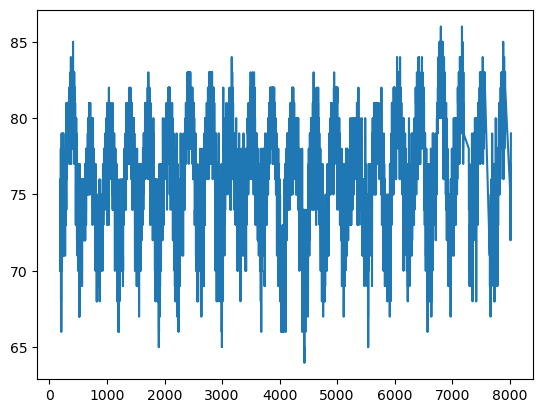

In [28]:
def sin_function(x, A, B, C, D):
    return A * np.sin(B * x + C) + D

X_data = X_train.select("index").collect().to_series()
y_data = y_train.select("TEMP").collect().to_series()
plt.plot(X_data, y_data)

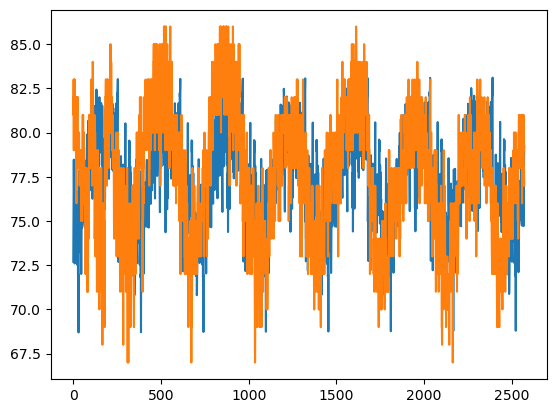

In [29]:
ARIMA = sm.tsa.arima.ARIMA
sltf = sm.tsa.STLForecast(y_data, ARIMA, model_kwargs=dict(order=(8, 1, 2), trend='t'), period=356)
sltf = sltf.fit()
forecast = sltf.forecast(y_test.select(pl.len()).collect().item() + 178)
plt.plot(forecast[178:])
plt.plot(y_test.select("TEMP").collect().to_series())

In [30]:
mae_loss = mae(y_test.select("TEMP").collect().to_series(), forecast[178:])
mse_loss = mse(y_test.select("TEMP").collect().to_series(), forecast[178:])
rmse_loss = np.sqrt(mse_loss)
print(f"MAE: {mae_loss}")
print(f"MSE: {mse_loss}")
print(f"RMSE: {rmse_loss}")

MAE: 2.804609885450946
MSE: 12.22089621299197
RMSE: 3.495839843727394
